In [21]:
# Bollinger Bands


import pandas as pd
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

#portfolio start value is $100,000
portfolio_value = 100000

# Reading in aapl data
aapl = pd.read_csv("Assignment 3&4-data files/{}.csv".format('AAPL'), usecols=[0, 4],index_col=0)
helper_data = aapl.copy()

# Indicator 4: Bollinger Bands of length 20
# using this resource https://medium.com/python-data/setting-up-a-bollinger-band-with-python-28941e2fa300

# Finding 20 day moving average and standard deviation
twentyDay = aapl['Close'].rolling(window=20)
aapl['Daily Return'] = aapl['Close'] / aapl['Close'].shift(periods=-1) - 1
aapl['BB_Middle'] = twentyDay.mean() 
helper_data['20 Day Moving Avg'] = twentyDay.mean() 
# aapl['20 Day Std Dev'] = twentyDay.std()
helper_data['20 Day Std Dev'] = twentyDay.std()

# Finding upper and lower band (moving avg +- 2*std dev)
aapl['BB_Lower'] = aapl['BB_Middle'] - (helper_data['20 Day Std Dev'] * 2)
helper_data['BB_Lower'] = helper_data['20 Day Moving Avg'] - (helper_data['20 Day Std Dev'] * 2)
aapl['BB_Upper'] = aapl['BB_Middle'] + (helper_data['20 Day Std Dev'] * 2)
helper_data['BB_Upper'] = helper_data['20 Day Moving Avg'] + (helper_data['20 Day Std Dev'] * 2)


# Sellsignal - Closing price crosses below upperband and was above upperband within 5 recent periods (0 or 1)
aapl['Sell_calc'] = aapl['Close'] - aapl['BB_Upper']
aapl['Buy_calc'] = aapl['Close'] - aapl['BB_Lower']
aapl['Buysignal'] = 0
aapl['Sellsignal'] = 0
aapl['Exitsignal'] = 0
aapl['State'] = 0

# ExitSignal for BB bhappens when close proce is larger than the Upper band
for i in range(0, len(aapl)):
    if (aapl['BB_Upper'].iloc[i] < aapl['Close'].iloc[i]):
        aapl['Exitsignal'].iloc[i] = 1
#         aapl['Close'].iloc[i]


# Sell signal
for i in range(0, len(aapl)):
    if ((aapl['Sell_calc'].iloc[i] < 0) and (aapl['Sell_calc'].iloc[i-1] > 0) and (aapl['Sell_calc'].iloc[i-2] > 0) and (aapl['Sell_calc'].iloc[i-3] > 0) and (aapl['Sell_calc'].iloc[i-4] > 0) and (aapl['Sell_calc'].iloc[i-5] > 0)):
        aapl['Sellsignal'].iloc[i]=1
#         aapl['Sellsignal'].iloc[i] = aapl['Close'].iloc[i]+10

# Buy signal
for i in range(0, len(aapl)):
    if ((aapl['Buy_calc'].iloc[i] > 0) and (aapl['Buy_calc'].iloc[i-1] < 0) and (aapl['Buy_calc'].iloc[i-2] < 0) and (aapl['Buy_calc'].iloc[i-3] < 0) and (aapl['Buy_calc'].iloc[i-4] < 0) and (aapl['Buy_calc'].iloc[i-5] < 0)):
        aapl['Buysignal'].iloc[i] = 1
#         aapl['Buysignal'].iloc[i] = aapl['Close'].iloc[i]-10




# STATE

# As confirmed with the TA:
# If there is no buy, sell or exit signal, the state should be maintained (stay the same as the state in the previous period).
# If in a long position and there's a buy signal, go into more long positions. 
# If in a long position and there's a sell signal, sell the long position and go into a short position.
# If in a short position and there's a buy signal, sell the short positions and go into a long position. 
# If in a short position and there's a sell signal, buy more short positions. 
# If in a short or long position and there's an exit signal, sell the positions. 

for i in range(1, len(aapl)):
    
#     maintain state
    if(aapl['Sellsignal'].iloc[i]==0 and aapl['Buysignal'].iloc[i]==0 and aapl['Exitsignal'].iloc[i]==0):
        aapl['State'].iloc[i]= aapl['State'].iloc[i-1]
    
#     buysignal
    if(aapl['Buysignal'].iloc[i]==1 and (aapl['State'].iloc[i-1]==1 or aapl['State'].iloc[i-1]==0)):
        # if you were long and you get a buy signal, buy more long positions
        # if you were neutral and you get a buy signal, buy long positions
        aapl['State'].iloc[i]=1
    if(aapl['Buysignal'].iloc[i]==1 and aapl['State'].iloc[i-1]==-1):
        # if prev state short and you get a buy sig, sell the short positions and buy long ones
        aapl['State'].iloc[i]=1
        
#       sellsignal
    if(aapl['Sellsignal'].iloc[i]==1 and aapl['State'].iloc[i-1]==1):
         #if sellsignal 1 and previous state was long, sell the long position and buy short
        aapl['State'].iloc[i]=-1
    if(aapl['Sellsignal'].iloc[i]==1 and (aapl['State'].iloc[i-1]==0 or aapl['State'].iloc[i-1]==-1)):
        # if you were neutral and you get a sell signal, buy short positions
        # if you were short and get a sell signal, buy more short positions
        aapl['State'].iloc[i]=-1

#        exit signal 
    if(aapl['Exitsignal'].iloc[i]==1):
        aapl['State'].iloc[i]= 0
    

    
# Filtering Exit Signals
aapl['ExitsignalFinal'] = 0

for i in range(1, len(aapl)):
    
    if(aapl['State'].iloc[i] != aapl['State'].iloc[i-1] and aapl['State'].iloc[i]==0):
        aapl['ExitsignalFinal'].iloc[i]=1
        
    
        
# Calculating Shares and Portfolio Value
aapl['Shares'] = 0

aapl['Portfolio Value'] = 0


for i in range(1, len(aapl)):
    
    if((aapl['Buysignal'].iloc[i] == 0) and (aapl['Sellsignal'].iloc[i] ==0) and (aapl['Exitsignal'].iloc[i] ==0)):
        aapl['Shares'].iloc[i]= aapl['Shares'].iloc[i-1]
    
    #buy condition when long or no position
    if(aapl['Buysignal'].iloc[i] ==1 and ((aapl['State'].iloc[i-1] == 1) or (aapl['State'].iloc[i-1] == 0))):
        shares_afford_long = portfolio_value/aapl['Close'].iloc[i]
        if (shares_afford_long >= 10):
            # if you can afford 10 shares, buy 10
            aapl['Shares'].iloc[i]= aapl['Shares'].iloc[i-1] + 10
            portfolio_value = portfolio_value - (aapl['Close'].iloc[i]*10)
        else:
            # if you can't afford 10 shares, buy as many as you can afford
            aapl['Shares'].iloc[i]= aapl['Shares'].iloc[i-1] + shares_afford_long
            portfolio_value = portfolio_value - (aapl['Close'].iloc[i]*shares_afford_long)
    
    #buy condition when short 
    if((aapl['Buysignal'].iloc[i] ==1) and (aapl['State'].iloc[i-1] == -1)):
        # Selling all short positions, so number of shares becomes 0
        portfolio_value = portfolio_value + aapl['Shares'].iloc[i-1]*aapl['Close'].iloc[i]
        aapl['Shares'].iloc[i] = 0

        shares_afford_long = portfolio_value/aapl['Close'].iloc[i]
        if (shares_afford_long >= 10):
            # if you can afford 10 shares, buy 10
            aapl['Shares'].iloc[i]= 10
            portfolio_value = portfolio_value - (aapl['Close'].iloc[i]*10)
        else:
            # if you can't afford 10 shares, buy as many as you can afford
            aapl['Shares'].iloc[i]= shares_afford_long
            portfolio_value = portfolio_value - (aapl['Close'].iloc[i]*shares_afford_long)
    

    # sell condition when long
    if((aapl['Sellsignal'].iloc[i] ==1) and aapl['State'].iloc[i-1] == 1):
        
        # Selling all short positions, so number of shares becomes 0
        portfolio_value = portfolio_value - aapl['Shares'].iloc[i-1]*aapl['Close'].iloc[i]
        aapl['Shares'].iloc[i] = 0

        shares_afford_short = portfolio_value/aapl['Close'].iloc[i]
        if (shares_afford_short >= 10):
            # if you can afford 10 shares, buy 10

            aapl['Shares'].iloc[i]= - 10
            portfolio_value = portfolio_value + 10*aapl['Close'].iloc[i]
        else:
            # if you can't afford 10 shares, buy as many as you can afford
            aapl['Shares'].iloc[i]= - shares_afford_short
            portfolio_value = portfolio_value + shares_afford_short*aapl['Close'].iloc[i]
    
    # sell condition when short or no position
    if((aapl['Sellsignal'].iloc[i] ==1) and ((aapl['State'].iloc[i-1] == -1) or (aapl['State'].iloc[i-1] == 0))):
        shares_afford_short = portfolio_value / aapl['Close'].iloc[i]
        if (shares_afford_short >= 10):
            # if you can afford 10 shares, buy 10
            aapl['Shares'].iloc[i]= aapl['Shares'].iloc[i-1]-10
            portfolio_value = portfolio_value + 10*aapl['Close'].iloc[i]
        else:
            # if you can't afford 10 shares, buy as many as you can afford
            aapl['Shares'].iloc[i]= aapl['Shares'].iloc[i-1]-shares_afford_short
            portfolio_value = portfolio_value + shares_afford_short*aapl['Close'].iloc[i]
    
                
    # exit condition
    if(aapl['ExitsignalFinal'].iloc[i] ==1 and aapl['State'].iloc[i-1] == 1):
        portfolio_value = portfolio_value + aapl['Shares'].iloc[i-1]*aapl['Close'].iloc[i]
        aapl['Shares'].iloc[i]= 0
    
        
    if(aapl['ExitsignalFinal'].iloc[i] ==1 and aapl['State'].iloc[i-1] == -1):
        portfolio_value = portfolio_value + aapl['Shares'].iloc[i-1]*aapl['Close'].iloc[i]
        aapl['Shares'].iloc[i]= 0
    
    aapl['Portfolio Value'].iloc[i] = portfolio_value
        
        

# summary statistics
stat_summary = pd.DataFrame(columns=['Price','State'])
for i in range(1, len(aapl)):
    if(aapl['State'].iloc[i] == 1 and aapl['State'].iloc[i-1] == -1):
            # Capturing exit and enter price
            temp_df = pd.DataFrame({'Price':aapl['Close'].iloc[i],'State':aapl['State'].iloc[i]}, index=[aapl.index[i]])
            stat_summary = stat_summary.append(temp_df)
            stat_summary = stat_summary.append(temp_df)
        
    if(aapl['State'].iloc[i] == -1 and aapl['State'].iloc[i-1] == 1):
        # Capturing exit and enter price
        temp_df = pd.DataFrame({'Price':aapl['Close'].iloc[i],'State':aapl['State'].iloc[i]}, index=[aapl.index[i]])
        stat_summary = stat_summary.append(temp_df)
        stat_summary = stat_summary.append(temp_df)

    if (aapl['State'].iloc[i] != 0 and aapl['State'].iloc[i-1] == 0):
        # Capturing enter price
        temp_df = pd.DataFrame({'Price':aapl['Close'].iloc[i],'State':aapl['State'].iloc[i]}, index=[aapl.index[i]])
        stat_summary = stat_summary.append(temp_df)

    if (aapl['State'].iloc[i] == 0 and aapl['State'].iloc[i-1] != 0):
        # Capturing exit price
        temp_df2 = pd.DataFrame({'Price':aapl['Close'].iloc[i],'State':aapl['State'].iloc[i]}, index=[aapl.index[i]])
        stat_summary = stat_summary.append(temp_df2) 
            
        

        
        
    
    
#     if (aapl['State'].iloc[i] !=0 and aapl['State'].iloc[i-1] == 0):       
#         temp_df = pd.DataFrame({'Price':aapl['Close'].iloc[i],'State':aapl['State'].iloc[i]}, index=[aapl.index[i]])
#         stat_summary = stat_summary.append(temp_df)

#     if (aapl['State'].iloc[i] == 0 and aapl['State'].iloc[i-1] != 0):
#         temp_df2 = pd.DataFrame({'Price':aapl['Close'].iloc[i],'State':aapl['State'].iloc[i]}, index=[aapl.index[i]])
#         stat_summary = stat_summary.append(temp_df2) 
        
stat_summary['ROI'] = 0
stat_summary['False/True Signal'] = False
# entering position price
start = stat_summary['Price'].iloc[::2]
# leaving position price
end = stat_summary['Price'].iloc[1::2]

stat_summary['Portfolio Value']=0
stat_summary['Shares']=0

# calculate ROI
calc_roi = []
for i in range(0,len(end)):
    calc_roi.append((end[i]-start[i])/start[i])
    
calc_roi = pd.Series(calc_roi)


if(len(stat_summary)%2 != 0):
    len_stats = len(stat_summary)-1
else: 
    len_stats = len(stat_summary)

roi_index = 0
for test in range(1,len_stats,2):
    if(stat_summary['State'].iloc[test-1] == -1):
        stat_summary['ROI'].iloc[test] = -1*calc_roi[roi_index]
    else: 
        stat_summary['ROI'].iloc[test] = calc_roi[roi_index]
    roi_index += 1

roi_index = 0
for test in range(1,len_stats,2):    
    stat_summary['False/True Signal'].iloc[test-1] = ''
    if (stat_summary['ROI'].iloc[test] > 0): 
        stat_summary['False/True Signal'].iloc[test] = True
    roi_index += 1

for test in range(0,len_stats,2):
    date_val = stat_summary.index[test]
    stat_summary['Portfolio Value'].iloc[test] = aapl['Portfolio Value'].loc[date_val]
    stat_summary['Portfolio Value'].iloc[test+1] = aapl['Portfolio Value'].loc[date_val]
    


stat_summary_final = pd.DataFrame(columns=['End Date','Start Price','End Price','Start State', 'End State', 'ROI', 'False/True Signal','Portfolio Starting Value', 'Portfolio Ending Value'])
stat_summary_final

for i in range(1,len_stats,2):
    temp_df = pd.DataFrame({'End Date': stat_summary.index[i], 'Start Price': stat_summary['Price'].iloc[i-1],'End Price': stat_summary['Price'].iloc[i],'Start State': stat_summary['State'].iloc[i-1],'End State': stat_summary['State'].iloc[i], 'ROI': stat_summary['ROI'].iloc[i], 'False/True Signal': stat_summary['False/True Signal'].iloc[i], 'Portfolio Starting Value': stat_summary['Portfolio Value'].iloc[i-1], 'Portfolio Ending Value':stat_summary['Portfolio Value'].iloc[i]}, index=[stat_summary.index[i-1]])
    stat_summary_final = stat_summary_final.append(temp_df)

stat_summary_final = stat_summary_final[['End Date','Start Price','End Price','Start State', 'End State', 'ROI', 'False/True Signal','Portfolio Starting Value','Portfolio Ending Value']]    


# df_trades dataframe
df_trades = stat_summary.copy()

if((len(df_trades)%2) != 0):
    len_df_trades = len(df_trades)-1
else: 
    len_df_trades = len(df_trades)
    
df_trades['Position'] = ''
for i in range(0, len_df_trades,2):
    df_trades['Position'].iloc[i]='Entering'
    df_trades['Position'].iloc[i+1]='Exiting'
    df_trades['Shares'].iloc[i+1]=''
    
# False/True Signal in AAPL dataframe
aapl['False/True Signal'] = 0

# based on if the signal was good, but this doesn't give a value for each day
# for j in range(len(stat_summary_final)):
#     for i in range(len(aapl)):   
#         if(stat_summary_final.index[j] == aapl.index[i]):
#             aapl['False/True Signal'].iloc[i] = stat_summary_final['False/True Signal'].iloc[j]


# instead use Daily return as true/false
for i in range(1,len(aapl)):   
    #if previous state is 1 and the return is positive, you are in the right position
    if(aapl['Daily Return'].iloc[i] > 0 and aapl['State'].iloc[i-1] == 1):
        aapl['False/True Signal'].iloc[i] = True
    if(aapl['Daily Return'].iloc[i] < 0 and aapl['State'].iloc[i-1] == -1):
        aapl['False/True Signal'].iloc[i] = True  
    else:
        aapl['False/True Signal'].iloc[i] = False
   
        
bb_all = aapl[['Close', 'Daily Return','Buysignal','Sellsignal', 'False/True Signal']].copy()
bb_all


/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Close,Daily Return,Buysignal,Sellsignal,False/True Signal
Date,,,,,
2017-01-03,116.150002,0.001121,0,0,0
2017-01-04,116.019997,-0.005060,0,0,False
2017-01-05,116.610001,-0.011025,0,0,False
2017-01-06,117.910004,-0.009076,0,0,False
2017-01-09,118.989998,-0.001007,0,0,False
2017-01-10,119.110001,-0.005344,0,0,False
2017-01-11,119.750000,0.004193,0,0,False
2017-01-12,119.250000,0.001764,0,0,False
2017-01-13,119.040001,-0.008000,0,0,False


In [22]:
# K-Nearest Neighbors (K-NN)

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# bb_train = bb_all.iloc[0:2]
# bb_test = bb_all.iloc[2:]

# bb_train


X = bb_all.iloc[:, [2, 3]].values
y = bb_all.iloc[:, 4].values

# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)



In [23]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = X_train.astype('bool')
y_train=y_train.astype('bool')
y_test = y_test.astype('bool')

# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

y_pred = y_pred.astype('bool')

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

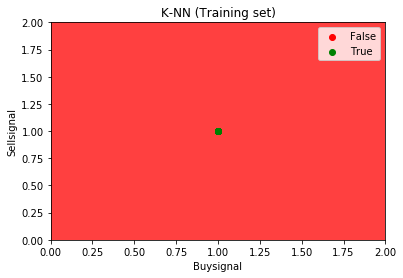

In [24]:

# Visualising the Training set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid((0,1,2),
                     (0,1,2))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('K-NN (Training set)')
plt.xlabel('Buysignal')
plt.ylabel('Sellsignal')
plt.legend()
plt.show()


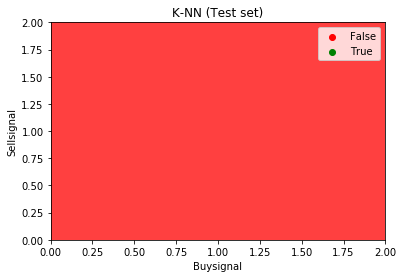

In [25]:

# Visualising the Test set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid((0,1,2),
                     (0,1,2))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('K-NN (Test set)')
plt.xlabel('Buysignal')
plt.ylabel('Sellsignal')
plt.legend()
plt.show()